In [1]:
import lightgbm as lgb
import json
import pickle
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 10)


In [2]:
df_train = pd.read_csv('train.csv', header=0)
df_test = pd.read_csv('test.csv', header=0)

In [3]:
df_train['train_flag'] = 1
df_test['train_flag'] = 0
df_test['Crop_Damage'] = 0
print(df_train.shape, df_test.shape)

df_data = pd.concat((df_train, df_test))
print(df_data.shape)
print(df_data)

(88858, 11) (59310, 11)
(148168, 11)
              ID  Estimated_Insects_Count  Crop_Type  Soil_Type  \
0      F00000001                      188          1          0   
1      F00000003                      209          1          0   
2      F00000004                      257          1          0   
3      F00000005                      257          1          1   
4      F00000006                      342          1          0   
...          ...                      ...        ...        ...   
59305  F00155937                     3337          1          0   
59306  F00155940                     3516          1          0   
59307  F00155941                     3702          1          0   
59308  F00155943                     3702          1          0   
59309  F00155944                     3895          1          0   

       Pesticide_Use_Category  Number_Doses_Week  Number_Weeks_Used  \
0                           1                  0                0.0   
1               

In [4]:
feature_cols = df_train.columns.tolist()
feature_cols.remove('ID')
feature_cols.remove('Crop_Damage')
feature_cols.remove('train_flag')
label_col = 'Crop_Damage'
print(feature_cols)

['Estimated_Insects_Count', 'Crop_Type', 'Soil_Type', 'Pesticide_Use_Category', 'Number_Doses_Week', 'Number_Weeks_Used', 'Number_Weeks_Quit', 'Season']


In [5]:
df_data['ID_value'] = df_data['ID'].apply(lambda x: x.strip('F')).astype('int')

In [6]:
df_data = df_data.sort_values(['ID_value'])

In [7]:
df_data = df_data.reset_index(drop=True)

In [8]:
df_data['Soil_Type_Damage'] = df_data.sort_values(['ID_value']).groupby(['Soil_Type'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Estimated_Insects_Count_Damage'] = df_data.sort_values(['ID_value']).groupby(['Estimated_Insects_Count'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values


df_data['Crop_Type_Damage'] = df_data.sort_values(['ID_value']).groupby(['Crop_Type'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values


df_data['Pesticide_Use_Category_Damage'] = df_data.sort_values(['ID_value']).groupby(['Pesticide_Use_Category'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values


df_data['Season_Damage'] = df_data.sort_values(['ID_value']).groupby(['Season'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values


df_data['Soil_Type_Damage_lag2'] = df_data.sort_values(['ID_value']).groupby(['Soil_Type'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Estimated_Insects_Count_Damage_lag2'] = df_data.sort_values(['ID_value']).groupby(['Estimated_Insects_Count'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Crop_Type_Damage_lag2'] = df_data.sort_values(['ID_value']).groupby(['Crop_Type'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Pesticide_Use_Category_Damage_lag2'] = df_data.sort_values(['ID_value']).groupby(['Pesticide_Use_Category'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Season_Damage_lag2'] = df_data.sort_values(['ID_value']).groupby(['Season'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

In [9]:
df_data.loc[df_data['train_flag'] == 0, 'Crop_Damage'] = -999

In [10]:
df_data['Crop_Damage_lag1'] = df_data['Crop_Damage'].shift(fill_value=-999)
df_data['Estimated_Insects_Count_lag1'] = df_data['Estimated_Insects_Count'].shift(fill_value=-999)
df_data['Crop_Type_lag1'] = df_data['Crop_Type'].shift(fill_value=-999)
df_data['Soil_Type_lag1'] = df_data['Soil_Type'].shift(fill_value=-999)
df_data['Pesticide_Use_Category_lag1'] = df_data['Pesticide_Use_Category'].shift(fill_value=-999)
df_data['Number_Doses_Week_lag1'] = df_data['Number_Doses_Week'].shift(fill_value=-999)
df_data['Number_Weeks_Used_lag1'] = df_data['Number_Weeks_Used'].shift(fill_value=-999)
df_data['Number_Weeks_Quit_lag1'] = df_data['Number_Weeks_Quit'].shift(fill_value=-999)
df_data['Season_lag1'] = df_data['Season'].shift(fill_value=-999)

df_data['Crop_Damage_lag2'] = df_data['Crop_Damage'].shift(periods=2,fill_value=-999)
df_data['Estimated_Insects_Count_lag2'] = df_data['Estimated_Insects_Count'].shift(periods=2,fill_value=-999)
df_data['Crop_Type_lag2'] = df_data['Crop_Type'].shift(fill_value=-999)
df_data['Soil_Type_lag2'] = df_data['Soil_Type'].shift(fill_value=-999)
df_data['Pesticide_Use_Category_lag2'] = df_data['Pesticide_Use_Category'].shift(periods=2,fill_value=-999)
df_data['Number_Doses_Week_lag2'] = df_data['Number_Doses_Week'].shift(periods=2,fill_value=-999)
df_data['Number_Weeks_Used_lag2'] = df_data['Number_Weeks_Used'].shift(periods=2,fill_value=-999)
df_data['Number_Weeks_Quit_lag2'] = df_data['Number_Weeks_Quit'].shift(periods=2,fill_value=-999)
df_data['Season_lag2'] = df_data['Season'].shift(periods=2,fill_value=-999)


In [11]:
df_data

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage,...,Season_lag1,Crop_Damage_lag2,Estimated_Insects_Count_lag2,Crop_Type_lag2,Soil_Type_lag2,Pesticide_Use_Category_lag2,Number_Doses_Week_lag2,Number_Weeks_Used_lag2,Number_Weeks_Quit_lag2,Season_lag2
0,F00000001,188,1,0,1,0,0.0,0,1,0,...,-999,-999,-999,-999,-999,-999,-999,-999.0,-999,-999
1,F00000002,188,1,1,1,0,NaN,0,2,-999,...,1,-999,-999,1,0,-999,-999,-999.0,-999,-999
2,F00000003,209,1,0,1,0,0.0,0,2,1,...,2,0,188,1,1,1,0,0.0,0,1
3,F00000004,257,1,0,1,0,0.0,0,2,1,...,2,-999,188,1,0,1,0,NaN,0,2
4,F00000005,257,1,1,1,0,0.0,0,2,1,...,2,1,209,1,0,1,0,0.0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148163,F00155941,3702,1,0,2,10,NaN,48,1,-999,...,2,0,3516,1,0,2,15,40.0,8,2
148164,F00155942,3702,1,0,2,10,25.0,18,3,0,...,1,-999,3516,1,0,2,20,32.0,10,2
148165,F00155943,3702,1,0,2,10,28.0,17,2,-999,...,3,-999,3702,1,0,2,10,NaN,48,1
148166,F00155944,3895,1,0,2,5,52.0,7,1,-999,...,2,0,3702,1,0,2,10,25.0,18,3


In [12]:
df_train, df_test = df_data[df_data.train_flag == 1], df_data[df_data.train_flag == 0]

In [13]:
df_train.drop(['train_flag'], inplace=True, axis=1)
df_test.drop(['train_flag'], inplace=True, axis=1)
df_test.drop([label_col], inplace=True, axis=1)

In [14]:
print(df_train.shape, df_test.shape)

(88858, 39) (59310, 38)


In [15]:
del df_data

In [16]:
missing_impute = -999

In [17]:
df_train['Number_Weeks_Used'] = df_train['Number_Weeks_Used'].apply(lambda x: missing_impute if pd.isna(x) else x)
df_test['Number_Weeks_Used'] = df_test['Number_Weeks_Used'].apply(lambda x: missing_impute if pd.isna(x) else x)

df_train['Number_Weeks_Used_lag1'] = df_train['Number_Weeks_Used_lag1'].apply(lambda x: missing_impute if pd.isna(x) else x)
df_test['Number_Weeks_Used_lag1'] = df_test['Number_Weeks_Used_lag1'].apply(lambda x: missing_impute if pd.isna(x) else x)

df_train['Number_Weeks_Used_lag2'] = df_train['Number_Weeks_Used_lag2'].apply(lambda x: missing_impute if pd.isna(x) else x)
df_test['Number_Weeks_Used_lag2'] = df_test['Number_Weeks_Used_lag2'].apply(lambda x: missing_impute if pd.isna(x) else x)

In [18]:
df_train, df_eval = train_test_split(df_train, test_size=0.40, random_state=42, shuffle=True, stratify=df_train[label_col])

In [19]:
feature_cols = df_train.columns.tolist()
feature_cols.remove('ID')
feature_cols.remove('Crop_Damage')
feature_cols.remove('ID_value')
label_col = 'Crop_Damage'
print(feature_cols)

['Estimated_Insects_Count', 'Crop_Type', 'Soil_Type', 'Pesticide_Use_Category', 'Number_Doses_Week', 'Number_Weeks_Used', 'Number_Weeks_Quit', 'Season', 'Soil_Type_Damage', 'Estimated_Insects_Count_Damage', 'Crop_Type_Damage', 'Pesticide_Use_Category_Damage', 'Season_Damage', 'Soil_Type_Damage_lag2', 'Estimated_Insects_Count_Damage_lag2', 'Crop_Type_Damage_lag2', 'Pesticide_Use_Category_Damage_lag2', 'Season_Damage_lag2', 'Crop_Damage_lag1', 'Estimated_Insects_Count_lag1', 'Crop_Type_lag1', 'Soil_Type_lag1', 'Pesticide_Use_Category_lag1', 'Number_Doses_Week_lag1', 'Number_Weeks_Used_lag1', 'Number_Weeks_Quit_lag1', 'Season_lag1', 'Crop_Damage_lag2', 'Estimated_Insects_Count_lag2', 'Crop_Type_lag2', 'Soil_Type_lag2', 'Pesticide_Use_Category_lag2', 'Number_Doses_Week_lag2', 'Number_Weeks_Used_lag2', 'Number_Weeks_Quit_lag2', 'Season_lag2']


In [20]:
feature_cols

['Estimated_Insects_Count',
 'Crop_Type',
 'Soil_Type',
 'Pesticide_Use_Category',
 'Number_Doses_Week',
 'Number_Weeks_Used',
 'Number_Weeks_Quit',
 'Season',
 'Soil_Type_Damage',
 'Estimated_Insects_Count_Damage',
 'Crop_Type_Damage',
 'Pesticide_Use_Category_Damage',
 'Season_Damage',
 'Soil_Type_Damage_lag2',
 'Estimated_Insects_Count_Damage_lag2',
 'Crop_Type_Damage_lag2',
 'Pesticide_Use_Category_Damage_lag2',
 'Season_Damage_lag2',
 'Crop_Damage_lag1',
 'Estimated_Insects_Count_lag1',
 'Crop_Type_lag1',
 'Soil_Type_lag1',
 'Pesticide_Use_Category_lag1',
 'Number_Doses_Week_lag1',
 'Number_Weeks_Used_lag1',
 'Number_Weeks_Quit_lag1',
 'Season_lag1',
 'Crop_Damage_lag2',
 'Estimated_Insects_Count_lag2',
 'Crop_Type_lag2',
 'Soil_Type_lag2',
 'Pesticide_Use_Category_lag2',
 'Number_Doses_Week_lag2',
 'Number_Weeks_Used_lag2',
 'Number_Weeks_Quit_lag2',
 'Season_lag2']

In [21]:
df_train.shape

(53314, 39)

In [22]:
df_train.head()

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage,...,Season_lag1,Crop_Damage_lag2,Estimated_Insects_Count_lag2,Crop_Type_lag2,Soil_Type_lag2,Pesticide_Use_Category_lag2,Number_Doses_Week_lag2,Number_Weeks_Used_lag2,Number_Weeks_Quit_lag2,Season_lag2
116030,F00122106,1385,0,0,2,20,15.0,26,3,0,...,2,-999,1296,0,0,2,20,37.0,7,2
113055,F00118978,1212,0,1,2,10,13.0,28,2,0,...,2,0,1212,0,1,2,10,8.0,29,2
144598,F00152185,169,1,1,3,25,20.0,0,2,0,...,2,-999,168,1,1,3,20,24.0,0,1
49542,F00052198,1385,0,1,2,40,-999.0,7,3,0,...,1,0,1385,0,1,2,40,27.0,14,2
117009,F00123147,916,0,1,2,5,26.0,15,2,0,...,1,-999,916,0,1,2,30,26.0,20,2


In [23]:
df_train['Season_lag2'].value_counts()
df_train['Season_lag1'].value_counts()
df_train['Season'].value_counts()
df_train['Season_Damage'].value_counts()
df_train['Season_Damage_lag2'].value_counts()
df_train['Soil_Type'].value_counts()
df_train['Soil_Type_lag1'].value_counts()
df_train['Soil_Type_lag2'].value_counts()
df_train['Soil_Type_Damage'].value_counts()
df_train['Soil_Type_Damage_lag2'].value_counts()
df_train['Crop_Type'].value_counts()
df_train['Crop_Type_lag1'].value_counts()
df_train['Crop_Type_lag2'].value_counts()
df_train['Crop_Type_Damage'].value_counts()
df_train['Crop_Type_Damage_lag2'].value_counts()
df_train['Estimated_Insects_Count'].value_counts()
df_train['Estimated_Insects_Count_lag1'].value_counts()
df_train['Estimated_Insects_Count_lag2'].value_counts()
df_train['Estimated_Insects_Count_Damage'].value_counts()
df_train['Estimated_Insects_Count_Damage_lag2'].value_counts()
df_train['Number_Doses_Week'].value_counts()
df_train['Number_Doses_Week_lag1'].value_counts()
df_train['Number_Doses_Week_lag2'].value_counts()
df_train['Number_Weeks_Quit'].value_counts()
df_train['Number_Weeks_Quit_lag1'].value_counts()
df_train['Number_Weeks_Quit_lag2'].value_counts()
df_train['Number_Weeks_Used'].value_counts()
df_train['Number_Weeks_Used_lag1'].value_counts()
df_train['Number_Weeks_Used_lag2'].value_counts()
df_train['Pesticide_Use_Category'].value_counts()
df_train['Pesticide_Use_Category_lag1'].value_counts()
df_train['Pesticide_Use_Category_lag2'].value_counts()
df_train['Pesticide_Use_Category_Damage'].value_counts()
df_train['Pesticide_Use_Category_Damage_lag2'].value_counts()
df_train['Crop_Damage_lag1'].value_counts()
df_train['Crop_Damage_lag2'].value_counts()




 0      26765
-999    21273
 1       4436
 2        840
Name: Crop_Damage_lag2, dtype: int64

In [24]:
cat_cols = ['Crop_Type', 'Soil_Type', 'Pesticide_Use_Category', 'Season', 'Crop_Type_lag1', 'Soil_Type_lag1', 'Pesticide_Use_Category_lag1', 'Season_lag1']

In [24]:
params = {}
params['learning_rate'] = 0.04
params['max_depth'] = 18
params['n_estimators'] = 3000
params['objective'] = 'multiclass'
params['boosting_type'] = 'gbdt'
params['subsample'] = 0.7
params['random_state'] = 42
params['colsample_bytree']=0.7
params['min_data_in_leaf'] = 55
params['reg_alpha'] = 1.7
params['reg_lambda'] = 1.11
params['class_weight']: {0: 0.44, 1: 0.4, 2: 0.37}

In [25]:
df_eval.columns

Index(['ID', 'Estimated_Insects_Count', 'Crop_Type', 'Soil_Type',
       'Pesticide_Use_Category', 'Number_Doses_Week', 'Number_Weeks_Used',
       'Number_Weeks_Quit', 'Season', 'Crop_Damage', 'ID_value',
       'Soil_Type_Damage', 'Estimated_Insects_Count_Damage',
       'Crop_Type_Damage', 'Pesticide_Use_Category_Damage', 'Season_Damage',
       'Soil_Type_Damage_lag2', 'Estimated_Insects_Count_Damage_lag2',
       'Crop_Type_Damage_lag2', 'Pesticide_Use_Category_Damage_lag2',
       'Season_Damage_lag2', 'Crop_Damage_lag1',
       'Estimated_Insects_Count_lag1', 'Crop_Type_lag1', 'Soil_Type_lag1',
       'Pesticide_Use_Category_lag1', 'Number_Doses_Week_lag1',
       'Number_Weeks_Used_lag1', 'Number_Weeks_Quit_lag1', 'Season_lag1',
       'Crop_Damage_lag2', 'Estimated_Insects_Count_lag2', 'Crop_Type_lag2',
       'Soil_Type_lag2', 'Pesticide_Use_Category_lag2',
       'Number_Doses_Week_lag2', 'Number_Weeks_Used_lag2',
       'Number_Weeks_Quit_lag2', 'Season_lag2'],
      dtype=

In [58]:
clf = lgb.LGBMClassifier(**params)
    
clf.fit(df_train[feature_cols], df_train[label_col], early_stopping_rounds=100, eval_set=[(df_train[feature_cols], df_train[label_col]), (df_eval[feature_cols], df_eval[label_col])], eval_metric='multi_error', verbose=True, categorical_feature=cat_cols)

eval_score = accuracy_score(df_eval[label_col], clf.predict(df_eval[feature_cols]))

print('Eval ACC: {}'.format(eval_score))

[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[1]	valid_0's multi_error: 0.164532	valid_0's multi_logloss: 0.489634	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.489457
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_error: 0.164532	valid_0's multi_logloss: 0.465225	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.464985
[3]	valid_0's multi_error: 0.164532	valid_0's multi_logloss: 0.444755	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.444527
[4]	valid_0's multi_error: 0.164532	valid_0's multi_logl

In [27]:
best_iter = clf.best_iteration_
params['n_estimators'] = best_iter
print(params)

{'learning_rate': 0.04, 'max_depth': 18, 'n_estimators': 1159, 'objective': 'multiclass', 'boosting_type': 'gbdt', 'subsample': 0.7, 'random_state': 42, 'colsample_bytree': 0.7, 'min_data_in_leaf': 55, 'reg_alpha': 1.7, 'reg_lambda': 1.11}


In [25]:
df_train = pd.concat((df_train, df_eval))
df_train['Crop_Damage'].value_counts()

0    74238
1    12307
2     2313
Name: Crop_Damage, dtype: int64

In [29]:
clf = lgb.LGBMClassifier(**params)

clf.fit(df_train[feature_cols], df_train[label_col], eval_metric='multi_error', verbose=False, categorical_feature=cat_cols)

# eval_score_auc = roc_auc_score(df_train[label_col], clf.predict(df_train[feature_cols]))
eval_score_acc = accuracy_score(df_train[label_col], clf.predict(df_train[feature_cols]))

print('ACC: {}'.format(eval_score_acc))

[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
ACC: 0.976861959530937


In [30]:
preds = clf.predict(df_test[feature_cols])
preds

array([1, 1, 1, ..., 0, 0, 0])

In [31]:
Counter(df_train['Crop_Damage'])

Counter({0: 74238, 1: 12307, 2: 2313})

In [32]:
Counter(preds)

Counter({1: 8550, 2: 530, 0: 50230})

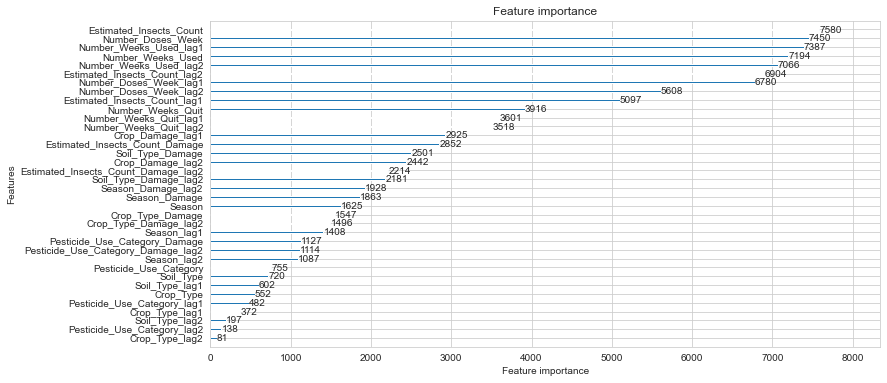

In [33]:
plt.rcParams['figure.figsize'] = (12, 6)
lgb.plot_importance(clf)
plt.show()

In [34]:
new=[[1,230,32,56,20.0,2,1,0,0.2,0.1,1.2,0.3,0.66,1.3,0.2,0.0,0.4,0.1,0,345,1,0,3,234,450,35.0,1,0,504,1,0,3,34,54,59.0,1]]

In [35]:
Ynew=clf.predict(new)

In [36]:
Ynew

array([0])

import pickle
file=open('harvestOutcome_model.pkl','wb')
pickle.dump(clf,file)

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

lg_pred=clf.predict(df_train[feature_cols])
print(accuracy_score(df_train[label_col],lg_pred))
print(confusion_matrix(df_train[label_col],lg_pred))
print(classification_report(df_train[label_col],lg_pred))
#eval_score_auc = roc_auc_score(df_train[label_col], clf.predict(df_train[feature_cols]))
#print(eval_score_auc)

0.976861959530937
[[74066   171     1]
 [  857 11441     9]
 [  115   903  1295]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     74238
           1       0.91      0.93      0.92     12307
           2       0.99      0.56      0.72      2313

    accuracy                           0.98     88858
   macro avg       0.96      0.83      0.88     88858
weighted avg       0.98      0.98      0.98     88858



In [65]:
import joblib
joblib.dump(clf, "harvest_model.pkl")

['harvest_model.pkl']

In [66]:
data=[[1,230,32,56,20.0,2,1,0,0.2,0.1,1.2,0.3,0.66,1.3,0.2,0.0,0.4,0.1,0,345,1,0,3,234,450,35.0,1,0,504,1,0,3,34,54,59.0,1]]

In [67]:
model=joblib.load("harvest_model.pkl")
print(model.predict(data))

[0]
